In [16]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [17]:
hn = 3
class Model(nn.Module):
     
    def __init__(self):
        super().__init__()
        self.stepLength = 2
        self.hidden = torch.zeros((1, hn))
        
        self.Whh = nn.Linear(hn, hn)
        self.Whx = nn.Linear(1, hn, bias = False)
        
        self.layer1 = nn.Linear(1 + hn, 32)
        self.layer2 = nn.Linear(32, 32)
        self.layer3 = nn.Linear(32, 32)
        self.layer4 = nn.Linear(32, 1)
      
    
    def forward_RNN(self, x):
        self.hidden = torch.tanh(self.Whh(self.hidden) + self.Whx(x))
        
        
    def forward_DNN(self, x):
        
        y = torch.cat((self.hidden.repeat(x.shape[0], 1), x), 1)
        
        y = torch.relu(self.layer1(y))
        y = torch.relu(self.layer2(y))
        y = torch.relu(self.layer3(y))
        y = self.layer4(y)*torch.exp(-0.01*x**2)
     
        return y
    
    def sample(self, n):
        total = 0
        x = torch.Tensor(4*np.random.random((1,1)) - 2)
        psi_old = self.forward_DNN(x)
        
        for i in range(n):
            x_new = x + self.stepLength*torch.Tensor(2*np.random.random((1,1)) - 1)
            psi_new = self.forward_DNN(x_new)
            
            if (psi_new/psi_old)**2 > np.random.random():
                x = x_new
                psi_old = psi_new
                total += 1
            
        return x, total
    
    def resetHidden(self):
        self.hidden = torch.zeros((1, hn))
        self.forward_RNN(torch.zeros((1, 1)))
        

In [18]:
torch.manual_seed(42)
np.random.seed(42)
model = Model()
optimizer = torch.optim.Adam(model.parameters())

### Using naive minimization of energy

In [21]:
epochs = 1000

n = 50
for epoch in tqdm(range(epochs)):   
    if epoch >= 0:
        N = 128
        
    if epoch > 500:
        N = 256
        
    if epoch > 850:
        N = 512
        
    if epoch > 950:
        N = 1024
        
    N = 10
    
    PE_acc = 0
    P_acc = 0
    E_acc = 0
    grad = 0
    
    for i in range(N):
        psi_total = 1
        
        model.resetHidden() 
        x1 = model.sample(n)[0].detach().requires_grad_()
        psi1 = model.forward_DNN(x1)
        
        model.forward_RNN(x1)
        x2 = model.sample(n)[0].detach().requires_grad_()
        psi2 = model.forward_DNN(x2)
        
        model.resetHidden()
        psi3 = model.forward_DNN(x2)
        model.forward_RNN(x2)
        psi4 = model.forward_DNN(x1)
        
        
        psi_total = psi1*psi2 + psi3*psi4
        dfdx, = torch.autograd.grad(psi_total, x1, create_graph=True)
        d2fdx2, = torch.autograd.grad(dfdx, x1, create_graph=True)
        
        kinetic1 = -0.5*d2fdx2/psi_total
        potential1 = 0.5*x1**2

        
        dfdx, = torch.autograd.grad(psi_total, x2, create_graph=True)
        d2fdx2, = torch.autograd.grad(dfdx, x2, create_graph=True)
        
        kinetic2 = -0.5*d2fdx2/psi_total
        potential2 = 0.5*x2**2
        
        
        E_L = (kinetic1 + potential1 + kinetic2 + potential2 + 1/torch.abs(x1-x2)).detach()
        PE_acc += psi_total/psi_total.detach()*E_L
        P_acc  += psi_total/psi_total.detach()
        E_acc  += E_L   
    
    PE_acc /= N
    P_acc  /= N
    E_acc  /= N
        
    counter = 0
    L2 = 0
    for param in model.parameters():
        counter += 1
        L2 += torch.mean(param**2)
    
    L2 /= counter
    
    loss = 2*(PE_acc - P_acc*E_acc)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    grad = 0
    for param in model.parameters():
        grad += torch.mean(param.grad**2)
    
    
    if epoch%10 == 0: 
        print(f"epoch: {epoch}, Grad: {grad}, Energy: {E_acc.item()}, N:{N}")

  0%|          | 1/1000 [00:00<03:51,  4.32it/s]

epoch: 0, Grad: 3675.14990234375, Energy: 48.50716018676758, N:10


  1%|          | 11/1000 [00:02<03:33,  4.64it/s]

epoch: 10, Grad: 6.076656341552734, Energy: 2.383451223373413, N:10


  2%|▏         | 21/1000 [00:04<03:46,  4.33it/s]

epoch: 20, Grad: 1.9211676120758057, Energy: 3.1535887718200684, N:10


  3%|▎         | 31/1000 [00:07<03:39,  4.42it/s]

epoch: 30, Grad: 35.65248107910156, Energy: 3.0159080028533936, N:10


  4%|▍         | 42/1000 [00:09<03:24,  4.68it/s]

epoch: 40, Grad: 2.2585439682006836, Energy: 2.537914276123047, N:10


  5%|▌         | 51/1000 [00:11<03:28,  4.54it/s]

epoch: 50, Grad: 1035.828125, Energy: 5.53912353515625, N:10


  6%|▌         | 61/1000 [00:13<03:39,  4.27it/s]

epoch: 60, Grad: 0.4169876277446747, Energy: 2.6882376670837402, N:10


  7%|▋         | 71/1000 [00:16<03:37,  4.26it/s]

epoch: 70, Grad: 0.7559623718261719, Energy: 2.231171131134033, N:10


  8%|▊         | 81/1000 [00:18<03:42,  4.14it/s]

epoch: 80, Grad: 311.6970520019531, Energy: 7.695523262023926, N:10


  9%|▉         | 91/1000 [00:20<03:39,  4.14it/s]

epoch: 90, Grad: 2.1402013301849365, Energy: 2.675381898880005, N:10


 10%|█         | 101/1000 [00:23<03:30,  4.26it/s]

epoch: 100, Grad: 0.734387993812561, Energy: 2.144899606704712, N:10


 11%|█         | 111/1000 [00:25<03:16,  4.53it/s]

epoch: 110, Grad: 27.569854736328125, Energy: 3.916541576385498, N:10


 12%|█▏        | 121/1000 [00:27<03:27,  4.25it/s]

epoch: 120, Grad: 5875.27978515625, Energy: 3.1232290267944336, N:10


 13%|█▎        | 131/1000 [00:29<03:08,  4.60it/s]

epoch: 130, Grad: 0.3413824439048767, Energy: 2.225665330886841, N:10


 14%|█▍        | 141/1000 [00:31<02:55,  4.90it/s]

epoch: 140, Grad: 0.3942825496196747, Energy: 2.092581272125244, N:10


 15%|█▌        | 151/1000 [00:34<03:05,  4.58it/s]

epoch: 150, Grad: 12.842550277709961, Energy: 2.061058521270752, N:10


 16%|█▌        | 161/1000 [00:36<03:10,  4.41it/s]

epoch: 160, Grad: 131.3934783935547, Energy: 2.032910108566284, N:10


 17%|█▋        | 171/1000 [00:38<03:15,  4.24it/s]

epoch: 170, Grad: 145.18008422851562, Energy: 11.054826736450195, N:10


 18%|█▊        | 181/1000 [00:41<03:05,  4.43it/s]

epoch: 180, Grad: 200.10585021972656, Energy: 2.706972599029541, N:10


 19%|█▉        | 191/1000 [00:43<03:05,  4.35it/s]

epoch: 190, Grad: 2.1203689575195312, Energy: 2.3697009086608887, N:10


 20%|██        | 201/1000 [00:45<03:01,  4.40it/s]

epoch: 200, Grad: 5.039854526519775, Energy: 2.5122437477111816, N:10


 21%|██        | 211/1000 [00:47<02:57,  4.45it/s]

epoch: 210, Grad: 51.73576354980469, Energy: 2.3047187328338623, N:10


 22%|██▏       | 221/1000 [00:50<03:00,  4.31it/s]

epoch: 220, Grad: 22.355363845825195, Energy: 2.175872564315796, N:10


 23%|██▎       | 231/1000 [00:52<02:57,  4.33it/s]

epoch: 230, Grad: 0.8849574327468872, Energy: 2.3268680572509766, N:10


 24%|██▍       | 242/1000 [00:55<02:44,  4.61it/s]

epoch: 240, Grad: 4.496447563171387, Energy: 1.8430366516113281, N:10


 25%|██▌       | 251/1000 [00:57<02:53,  4.33it/s]

epoch: 250, Grad: 736.5738525390625, Energy: 19.44083023071289, N:10


 26%|██▌       | 261/1000 [00:59<02:50,  4.33it/s]

epoch: 260, Grad: 729.458984375, Energy: 3.9844391345977783, N:10


 27%|██▋       | 271/1000 [01:01<02:42,  4.48it/s]

epoch: 270, Grad: 0.05937478691339493, Energy: 1.5036715269088745, N:10


 28%|██▊       | 281/1000 [01:03<02:41,  4.44it/s]

epoch: 280, Grad: 33.22459030151367, Energy: 1.9698501825332642, N:10


 29%|██▉       | 291/1000 [01:06<02:44,  4.30it/s]

epoch: 290, Grad: 2.6178956031799316, Energy: 2.6569418907165527, N:10


 30%|███       | 301/1000 [01:08<02:27,  4.74it/s]

epoch: 300, Grad: 5.577933311462402, Energy: 2.2590365409851074, N:10


 31%|███       | 312/1000 [01:10<02:16,  5.04it/s]

epoch: 310, Grad: 575.1285400390625, Energy: 2.701413631439209, N:10


 32%|███▏      | 321/1000 [01:12<02:32,  4.45it/s]

epoch: 320, Grad: 1.422418475151062, Energy: 2.0320663452148438, N:10


 33%|███▎      | 331/1000 [01:14<02:40,  4.16it/s]

epoch: 330, Grad: 4309.06787109375, Energy: 3.7211544513702393, N:10


 34%|███▍      | 341/1000 [01:17<02:37,  4.19it/s]

epoch: 340, Grad: 1.5290179252624512, Energy: 2.194408893585205, N:10


 34%|███▍      | 343/1000 [01:17<02:29,  4.40it/s]


KeyboardInterrupt: 

In [22]:
def f(x):
    x_lin = torch.linspace(-8, 8, 100).reshape(100,-1)
    dx = x_lin[1] - x_lin[0] 
    model.resetHidden()
    psi1 = model.forward_DNN(x_lin)[:,0].detach().numpy()

    x = torch.Tensor([[x]])
    #y = torch.Tensor([[y]])
    
    model.forward_RNN(x)
    psi2 = model.forward_DNN(x_lin)[:,0].detach().numpy()

    #model.forward_RNN(y)
    #psi3 = model.forward_DNN(x_lin)[:,0].detach().numpy()

    plt.plot(x_lin[:,0], 1/dx*psi1**2/np.sum(psi1**2), "b")
    plt.plot(x_lin[:,0], 1/dx*psi2**2/np.sum(psi2**2), "r")
    #plt.plot(x_lin[:,0], psi3**2/np.sum(psi3**2))
    plt.plot(x, 0.01, "bo")
    #plt.plot(y, 0.01, "ro")
    #plt.xlim((-3,3))
    plt.ylim((0, 0.8))

    plt.show()
    
def g(x):
    model.resetHidden()

    x = torch.Tensor([[x]])
    #y = torch.Tensor([[y]])

    plt.plot(model.hidden.detach().numpy(), "bo")
    model.forward_RNN(x)
    #model.forward_RNN(y)

    plt.plot(model.hidden.detach().numpy(), "ro")
    plt.xlim((-7,7))
    plt.ylim((-1, 1))

    plt.show()

interact(f, x=(-4.0, 4., 0.025));
interact(g, x=(-4.0, 4., 0.1));

interactive(children=(FloatSlider(value=0.0, description='x', max=4.0, min=-4.0, step=0.025), Output()), _dom_…

interactive(children=(FloatSlider(value=0.0, description='x', max=4.0, min=-4.0), Output()), _dom_classes=('wi…

In [15]:
N = 10000

pos = []
E = 0
for i in tqdm(range(N)):
    model.resetHidden() 
    x1 = model.sample(10)[0][0,0].detach().numpy()
    pos.append(x1)

100%|██████████| 10000/10000 [00:16<00:00, 592.91it/s]


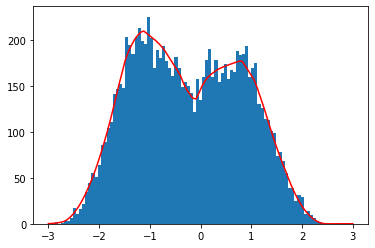

In [16]:
x_lin = torch.linspace(-3, 3, 100).reshape(100,-1)

dx = x_lin[1] - x_lin[0]

model.resetHidden()
psi = model.forward_DNN(x_lin)[:,0].detach().numpy()


#model.forward_RNN(y)
#psi3 = model.forward_DNN(x_lin)[:,0].detach().numpy()



bins = np.linspace(-3, 3, 100)
plt.hist(pos, bins=bins)
plt.plot(x_lin[:,0], N*psi**2/np.sum(psi**2), "r")
plt.show()

In [57]:
N = 10000
pos = []
E = 0
x = torch.Tensor([[2]])


for i in tqdm(range(N)):
    model.resetHidden()
    model.forward_RNN(x)
    
    x2 = model.sample(50)[0][0,0].detach().numpy()
    pos.append(x2)

100%|██████████| 10000/10000 [01:18<00:00, 126.68it/s]


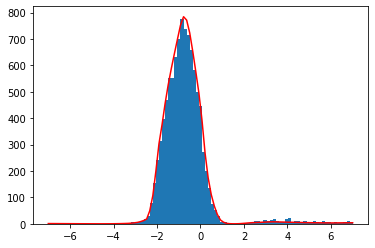

In [60]:
x_lin = torch.linspace(-7, 7, 100).reshape(100,-1)

dx = x_lin[1] - x_lin[0]

model.resetHidden()
model.forward_RNN(x)
psi2 = model.forward_DNN(x_lin)[:,0].detach().numpy()

bins = np.linspace(-7, 7, 100)
plt.hist(pos, bins=bins)
plt.plot(x_lin[:,0], N*psi2**2/np.sum(psi2**2), "r")
plt.show()

In [40]:
model.resetHidden()
print(model.sample(100))

(tensor([[-1.4604]]), 66)


In [ ]:
x_lin = torch.linspace(-4, 4, 100).reshape(100,-1)
psi = model.forward(x_lin)[:,0].detach().numpy()

plt.plot(x_lin[:,0], psi**2)
plt.plot(x_lin[:,0], 1/np.sqrt(np.pi)*np.exp(-x_lin[:,0]**2), "--")
plt.legend(["DNN", "analytical"])
plt.show()


## Estimating energy

In [ ]:
N = 10000

E = 0
for i in tqdm(range(N)):
    model.resetHidden() 
    x1 = model.sample(10)[0].detach().requires_grad_()
    psi1 = model.forward_DNN(x1)

    model.forward_RNN(x1)
    x2 = model.sample(10)[0].detach().requires_grad_()
    psi2 = model.forward_DNN(x2)


    psi_total = psi1*psi2
    dfdx, = torch.autograd.grad(psi_total, x1, create_graph=True)
    d2fdx2, = torch.autograd.grad(dfdx, x1, create_graph=True)

    kinetic1 = -0.5*d2fdx2/psi_total
    potential1 = 0.5*x1**2


    dfdx, = torch.autograd.grad(psi_total, x2, create_graph=True)
    d2fdx2, = torch.autograd.grad(dfdx, x2, create_graph=True)

    kinetic2 = -0.5*d2fdx2/psi_total
    potential2 = 0.5*x2**2



    E += (kinetic1 + potential1 + kinetic2 + potential2 + 1/torch.abs(x1-x2)).detach()

E = E/N

print(E.item())

In [ ]:
model.resetHidden() 
x1 = torch.Tensor([[0]]).requires_grad_()
psi1 = model.forward_DNN(x1)

model.forward_RNN(x1)
x2 = torch.Tensor([[0]]).requires_grad_()
psi2 = model.forward_DNN(x2)
z
psi_total = psi1*psi2
dfdx, = torch.autograd.grad(psi_total, x1, create_graph=True)
d2fdx2, = torch.autograd.grad(dfdx, x1, create_graph=True)

print(d2fdx2/psi_total)



## Testing auto grad

In [ ]:
x = [torch.Tensor([3]).requires_grad_(), torch.Tensor([6]).requires_grad_()]
y = torch.Tensor([4, 8]).requires_grad_()

f = torch.Tensor(x)**3*y**2

print(f)
#f.backward()
#print(x.grad, y.grad)

dfdx = [torch.autograd.grad(a, b, create_graph=True)[0] for a, b in zip(f, x)]
print(dfdx)

d2fdx2 = [torch.autograd.grad(a, b, create_graph=True)[0] for a, b in enumerate(dfdx, x)]

print(d2fdx2)

#d2fdx2.backward()
#print(x.grad, y.grad)

#print(dfdx)


#ddfdxdx, = torch.autograd.grad(dfdx, x, create_graph=True)
#print(ddfdxdx.grad_fn(x)[1])